## Project Description

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to underage people.

While conducting this evaluation, the following must be kept in mind:
*   The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol.
*   Computer vision methods can be used to determine the age of a person from a photo.
*   The task then is to build and evaluate a model for verifying people's age.

## Initialization

In [1]:
## initialization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

The dataset is stored in the `/datasets/faces/` folder and contains the following:
- The `final_files` folder with 7.6k photos
- The `labels.csv` label file with two columns: `file_name` and `real_age`

There are a lot image files so it's best to avoid reading them all at once and to instead build a generator with the ImageDataGenerator generator. 

In [4]:
# load the labels.csv file
labels = pd.read_csv('./faces/labels.csv')

## EDA

In [5]:
# preview the data in labels
labels.head()

# get info about labels
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


There are 7,591 rows (labels) in our DataFrame. The data types are as expected.



In [6]:
# group real_age by the count of associated files and save it in the ages dataframe
ages = labels.groupby('real_age')['file_name'].count().reset_index()

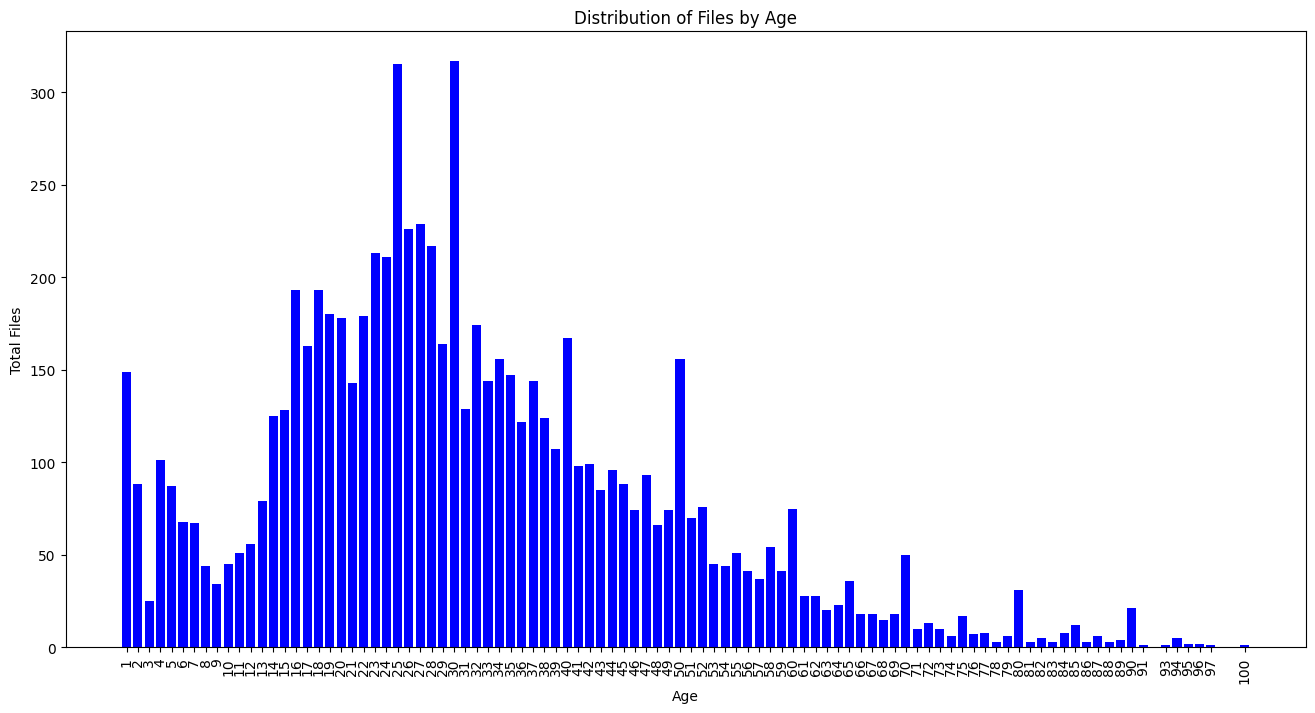

In [7]:
# set the figure size
plt.figure(figsize=(16, 8))

# plot a bar chart of real_age by the count of file names
plt.bar(ages['real_age'], ages['file_name'], color='blue')

# set the plot x-axis and y-axis labels
plt.xlabel('Age')
plt.ylabel('Total Files')

# set the plot title
plt.title('Distribution of Files by Age')

# set the x-ticks and rotate the labels by 90 degrees
plt.xticks(ages['real_age'], rotation=90)

# show the plot
plt.show()

The distribution of photos by age are skewed-left. The greatest concentration of photos are of people ranging from around 16 to 30 years old. This data will be helpful since it's important to train our model with photos of people who are relatively near in age to 21 year olds so we can address the task well.

We have less photos of adolescents and a generally downward trend in the number of photos for ages after 30.

In [11]:
# calculate interquartile range of real_age
q1 = labels['real_age'].quantile(0.25)
q3 = labels['real_age'].quantile(0.75)
iqr = q3 - q1

# calculate outliers
min_outliers = q1 - 1.5 * iqr
max_outliers = q3 + 1.5 * iqr

print(min_outliers, max_outliers)


-10.0 70.0


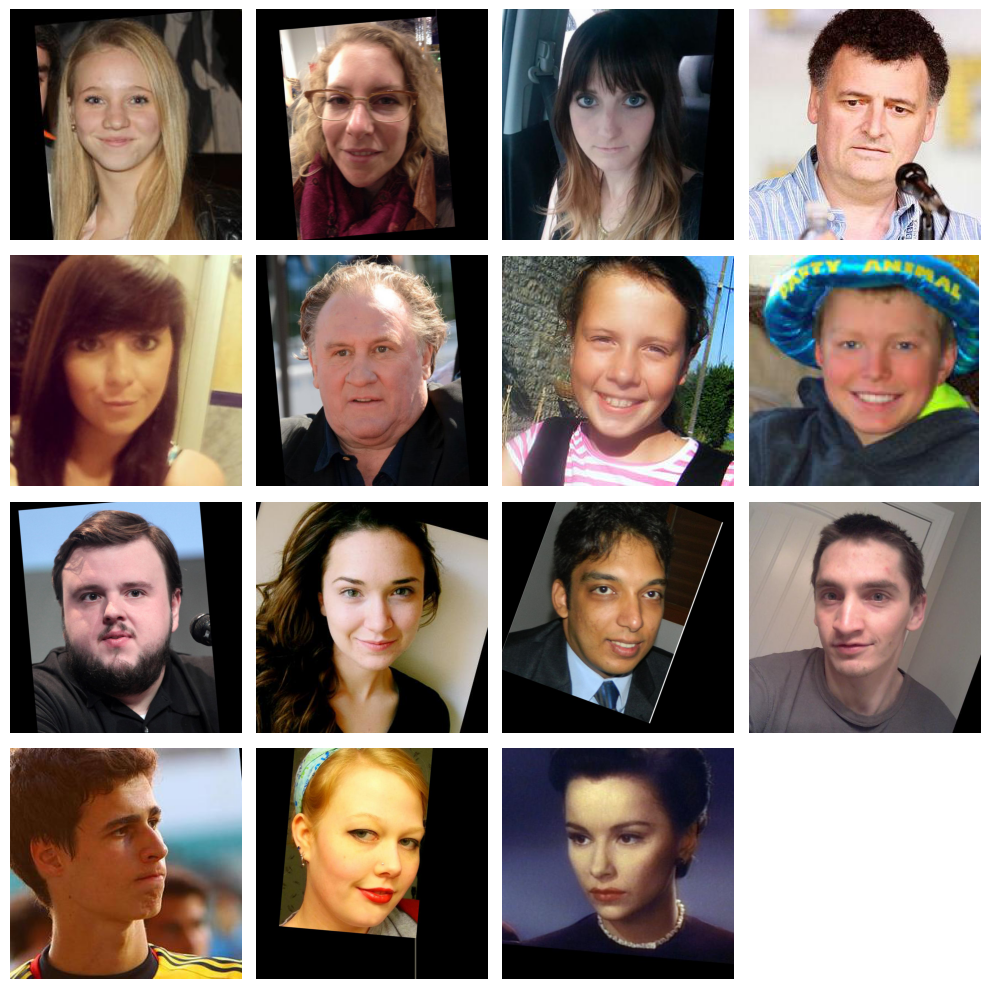

In [8]:
from PIL import Image
import os

# set the figure size
plt.figure(figsize=(10, 10))

# set the number of images to display
num_images = 15

# set the path to the images
path = '/datasets/faces/final_files/'

# get the list of files in the path
files = os.listdir(path)

# loop through the number of images to display
for i in range(num_images):
    # select a random file
    file = np.random.choice(files)

    # read the image using Pillow
    img = Image.open(os.path.join(path, file))

    # plot the image
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Findings

From the random sample of 15 images displayed, we can observe many things.

The quality of the images vary significantly, and this variability can make the task of predicting age more difficult.

There is also a lot of variation in the image brightness, whether it's in color or is black and white, what the background behind the person is, and what facial expressions they are making, which can impact the model's ability to generalize. Some faces are not cenetered in the photo and are displayed at different angles which induces additional complexity into the model.

Since the age distribution is skewed toward younger people, the model will likely perform better on those age groups. Likely, certain genders and ethnicities are underrepresented in the data set, which may result in model bias (the model performs poorly for these underrepresented groups).


<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Good job!

</div>

## Model Training

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [9]:
# import the necessary libraries for the model
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# create a function to load the train part of the dataset
def load_train(path):

    """
    It loads the train part of dataset from path
    
    """
    # load the labels.csv file from the provided path 
    labels = pd.read_csv(path + 'labels.csv')

    # create an instance of ImageDataGenerator, set the validation split to 0.25, and apply augmentation techniques
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                        rescale=1./255,
                                        brightness_range=[0.8, 1.2],
                                        horizontal_flip=True,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        rotation_range=10,
                                        shear_range=0.1,
                                        zoom_range=0.2,
                                        fill_mode='nearest'
                                       )

    # create a generator for the train dataset
    train_gen_flow = train_datagen.flow_from_dataframe(
       dataframe=labels,
       directory=path + 'final_files/',
       x_col='file_name',
       y_col='real_age',
       target_size=(150, 150),
       batch_size=16,
       class_mode='raw',
       subset='training',
       seed=12345)

    return train_gen_flow

In [ ]:
# apply the function to load the train dataset
train_gen_flow = load_train('/datasets/faces/')


In [ ]:
# create a function to load the validation part of the dataset
def load_test(path='/datasets/faces/final_files/'):

    """
    It loads the validation/test part of dataset from path
    """

    # load the labels.csv file from the provided path
    labels = pd.read_csv(path + 'labels.csv')
    
    # create an instance of ImageDataGenerator and set the validation split to 0.25
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

    # create a generator for the validation dataset
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

In [ ]:
# apply the function to load the test dataset
test_gen_flow = load_test('/datasets/faces/')


In [ ]:
# create a function to train the model
def create_model(input_shape):

    """
    It defines the model
    """

    # load the ResNet50 model with the top removed
    backbone = ResNet50(
            input_shape=input_shape,
            weights='imagenet',
            include_top=False
            )

    # freeze ResNet50 with the top removed
    backbone.trainable = False
    
    # create a Sequential model
    model = Sequential()

    # add the ResNet50 model to the Sequential model
    model.add(backbone)

    # add a GlobalAveragePooling2D layer
    model.add(GlobalAveragePooling2D())

    # add a Dense layer with 1 neuron and the ReLU activation function
    model.add(Dense(1, activation='relu'))
    
    3# create an instance of the Adam optimizer with a learning rate of 0.0005
    optimizer = Adam(learning_rate=0.0005)

    # compile the model with the Adam optimizer, the mean squared error loss function, and the mean absolute error metric
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [ ]:
# apply the function to create the model and save it in the model variable
model = create_model((150, 150, 3))

In [ ]:
# use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
# create a function to train the model
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """

    # set the steps_per_epoch and validation_steps if not provided
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(train_data)
    
    '''
    if steps_per_epoch is None:
        steps_per_epoch = int(len(train_data) / batch_size)
    if validation_steps is None:
        validation_steps = int(len(test_data) / batch_size)
     '''

    # check if test_data yields data
    print("Checking test_data...")  

    # create an iterator for the test_data generator 
    # consume the first element of the iterator to check if it yields data and print a success message if it does
    try:
        next(test_data) 
        print("test_data yielded data successfully.")
    # print an error message if the iterator is empty or exhausted
    except StopIteration:
        print("test_data is empty or exhausted.")

        # return the model (or raise an exception)
        return model 

    # train the model
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              callbacks=[early_stopping],
              verbose=1)

    return model

<div class="alert alert-info">
Also fixed! 
    
Two questions though:
    
1) Would I ever need to reset the test data? For instance, it I am not running the notebook over again from start to finish but instead just re-training the model?
    
2) How is the batch_size param in model_train() related to the batch_size param in setting train_gen_flow and test_gen_flow? I don't see any code that connects the two. Should they be set to the same values?
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Correct

1. Nope
2. When you use a generator to load the data `batch_size` you set in generator is used. When you use a regular datafile, `batch_size` you set in .fit() method is used

</div>

In [ ]:
# apply the function to train the model
train_model(model, train_gen_flow, load_test, epochs=30, batch_size=32)


### Output

Place the output from the GPU platform as an Markdown cell here.

In [ ]:
Found 511 validated image filenames.
Checking test_data...
test_data yielded data successfully.
Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - loss: 310.1556 - mae: 12.9539 - val_loss: 281.9431 - val_mae: 12.4587
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 230.9236 - mae: 11.8464 - val_loss: 147.1689 - val_mae: 10.0728
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 310.8566 - mae: 12.8769 - val_loss: 205.2580 - val_mae: 10.9376
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 283.9547 - mae: 13.6837 - val_loss: 171.4251 - val_mae: 10.8259
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 404.0071 - mae: 14.7212 - val_loss: 172.4811 - val_mae: 9.9344
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 230.3390 - mae: 11.6256 - val_loss: 350.4415 - val_mae: 16.2210
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 326.5589 - mae: 12.8912 - val_loss: 289.6594 - val_mae: 14.9331
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 391.4218 - mae: 15.3905 - val_loss: 292.6642 - val_mae: 14.5376
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 503.5215 - mae: 18.0936 - val_loss: 438.9468 - val_mae: 14.7513
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 201.2019 - mae: 11.3561 - val_loss: 300.7877 - val_mae: 14.3913
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 306.6414 - mae: 14.9471 - val_loss: 204.7602 - val_mae: 11.3273
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 252.7413 - mae: 12.6390 - val_loss: 86.0003 - val_mae: 7.6185
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 244.4626 - mae: 12.7907 - val_loss: 168.0252 - val_mae: 9.8916
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 219.5639 - mae: 10.3755 - val_loss: 241.0423 - val_mae: 12.3451
Epoch 15/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 377.0818 - mae: 14.8579 - val_loss: 144.4636 - val_mae: 9.6733
Epoch 16/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 448.5305 - mae: 16.6586 - val_loss: 459.0579 - val_mae: 16.3187
Epoch 17/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 374.4723 - mae: 14.1752 - val_loss: 315.7296 - val_mae: 15.6573
Epoch 18/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 309.0229 - mae: 12.8587 - val_loss: 479.7961 - val_mae: 16.0061
Epoch 19/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 326.7842 - mae: 14.7575 - val_loss: 190.5705 - val_mae: 12.1951
Epoch 20/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 196.0743 - mae: 10.9295 - val_loss: 117.5582 - val_mae: 7.9587
Epoch 21/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 327.7450 - mae: 14.6380 - val_loss: 127.5417 - val_mae: 10.2435
Epoch 22/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 202.7236 - mae: 10.7749 - val_loss: 97.6145 - val_mae: 7.4482
<Sequential name=sequential, built=True>

## Conclusions

A mean absolute error of 7.44 means our predictions are off by 7.44 years on average. This isn't great because our task requires that we have high accuracy to determine an person's age for verification of their eligibility and legality to purchase alcohol.

To improve our model, we should use a larger dataset with more diverse examples. Our model is limited in the distribution of ages present in the dataset which makes it harder to learn the necessary patterns to accurate predict age. Factors like a person's pose, facial expression, and any accessories they are wearing (hats, glasses, etc.) increases the model's complexity and reduces its ability to generalize well.


Outliers in age or atypical images may disproportionately increase the squared error (our model's loss function), which would inflate the MSE.
Overfitting or Underfitting:

We should remove outliers or poor-quality images to reduce confusion within the model and balance the dataset across age groups to improve data quality. 

However, as the model currently stands, it's not ready for our task. The risk of selling alcohol to minors is far too high.